In [1]:
import cv2
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from keras.regularizers import l2
from tensorflow.keras.applications import MobileNet
import os
import matplotlib.pyplot as plt
import random
import shutil
import numpy as np

In [2]:
mobile_net = MobileNet(weights = "imagenet", include_top = False, input_shape = (224,224,3))

In [3]:
for layer in mobile_net.layers[:]:
    layer.trainable = False

for layer in mobile_net.layers[:]:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001F66D720670> False
<keras.layers.convolutional.Conv2D object at 0x000001F6796D0820> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F6796D0EE0> False
<keras.layers.advanced_activations.ReLU object at 0x000001F679764310> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F6797A4B20> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F60017A520> False
<keras.layers.advanced_activations.ReLU object at 0x000001F60017A7C0> False
<keras.layers.convolutional.Conv2D object at 0x000001F600183730> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F6001939A0> False
<keras.layers.advanced_activations.ReLU object at 0x000001F60019B3D0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001F600193F70> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001F60018E2E0> False
<keras.lay

In [16]:
model = Sequential()

# inserting the conv layers on top of the base classification layer
model.add(mobile_net)  

# creating the classification layers
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu', use_bias = True))
model.add(Dense(units=1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               25690624  
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 28,920,001
Trainable params: 25,691,137
Non-trainable params: 3,228,864
_________________________________________________________________


In [18]:
Dataset = r"C:\Users\Teja Nikhil\OneDrive\Desktop\COVID-19_Radiography_Dataset\covid_direc"

In [19]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                                                    #width_shift_range = 0.2,
                                                                    #brightness_range = [0.2,1],
                                                                    #horizontal_flip = True,
                                                                    #zoom_range = 0.2,
                                                                    validation_split=0.2)

train_data = train_datagen.flow_from_directory(Dataset,
                                                                            subset = 'training',
                                                                            class_mode = 'binary',
                                                                            target_size = (224, 224) 
                                                                            )

validation_data =  train_datagen.flow_from_directory(Dataset,
                                                                                     subset = 'validation',
                                                                                     class_mode = 'binary',
                                                                                     target_size = (224, 224)
                                                                                     )

Found 5779 images belonging to 2 classes.
Found 1444 images belonging to 2 classes.


In [20]:
history = model.fit(train_data, validation_data = validation_data, epochs = 20, batch_size = 32, steps_per_epoch = 10)

Epoch 1/20
10/10 [==============================] - 44s 4s/step - loss: 19.4330 - accuracy: 0.5875 - val_loss: 4.3802 - val_accuracy: 0.8213
Epoch 2/20
10/10 [==============================] - 40s 4s/step - loss: 3.4639 - accuracy: 0.8000 - val_loss: 0.9530 - val_accuracy: 0.9252
Epoch 3/20
10/10 [==============================] - 43s 5s/step - loss: 1.0653 - accuracy: 0.9000 - val_loss: 1.7832 - val_accuracy: 0.8262
Epoch 4/20
10/10 [==============================] - 51s 6s/step - loss: 0.8113 - accuracy: 0.8813 - val_loss: 0.5297 - val_accuracy: 0.9425
Epoch 5/20
10/10 [==============================] - 43s 5s/step - loss: 0.5595 - accuracy: 0.9219 - val_loss: 0.6071 - val_accuracy: 0.9425
Epoch 6/20
10/10 [==============================] - 45s 5s/step - loss: 0.4190 - accuracy: 0.9312 - val_loss: 0.4973 - val_accuracy: 0.9418
Epoch 7/20
10/10 [==============================] - 41s 4s/step - loss: 0.4177 - accuracy: 0.9625 - val_loss: 0.4694 - val_accuracy: 0.9439
Epoch 8/20
10/10 [=

In [17]:
model_json = model.to_json()
with open("covid_mobilenet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("covid_mobilenet.h5")

In [6]:
model.load_weights("covid_mobilenet.h5")

In [7]:
def read_img(img_path):
    image = cv2.imread(img_path)
    resized_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
    return resized_image

test_image1 = read_img(r"C:\Users\Teja Nikhil\OneDrive\Desktop\COVID-19_Radiography_Dataset\Testing\COVID-12.png")
print(f"Shape of the image: {test_image1.shape}")
test_image1 = test_image1[np.newaxis,:,:,:]
model.predict(test_image1)

Shape of the image: (224, 224, 3)


array([[7.7371194e-05]], dtype=float32)

In [19]:
Test_Dir = r"C:\Users\Teja Nikhil\OneDrive\Desktop\COVID-19_Radiography_Dataset\Testing"
Testing_Images = os.listdir(Test_Dir)
Predictions = []
for i in Testing_Images:
    direc = os.path.join(Test_Dir, i)
    test_image = read_img(direc)
    test_image = test_image[np.newaxis,:,:,:]
    Predictions.append(model.predict(test_image))
    
preds = np.array(Predictions)
(preds)

array([[[7.7371194e-05]],

       [[2.4021772e-05]],

       [[4.6865476e-05]],

       [[4.0807307e-05]],

       [[5.2336752e-03]],

       [[2.7920702e-05]],

       [[2.0073205e-02]],

       [[2.7939677e-04]],

       [[3.7737489e-03]],

       [[3.4572819e-01]]], dtype=float32)

In [10]:
Test_Dir = r"C:\Users\Teja Nikhil\Semester - III\Covid Diagnostics_ICS Endsem\Train CXR\Positive CXR"
Testing_Images = os.listdir(Test_Dir)
Predictions = []
for i in Testing_Images:
    direc = os.path.join(Test_Dir, i)
    test_image = read_img(direc)
    test_image = test_image[np.newaxis,:,:,:]
    Predictions.append(list(model.predict(test_image)))
    
list(Predictions)

[[array([3.1659034e-05], dtype=float32)],
 [array([0.00021997], dtype=float32)],
 [array([1.316712e-06], dtype=float32)],
 [array([0.00013942], dtype=float32)],
 [array([0.00043035], dtype=float32)],
 [array([8.7839086e-05], dtype=float32)],
 [array([2.867003e-06], dtype=float32)],
 [array([4.7037278e-07], dtype=float32)],
 [array([0.00069422], dtype=float32)],
 [array([0.00169501], dtype=float32)],
 [array([1.9237772e-05], dtype=float32)],
 [array([4.8066024e-05], dtype=float32)],
 [array([1.4073452e-08], dtype=float32)],
 [array([0.00010906], dtype=float32)],
 [array([7.840425e-07], dtype=float32)],
 [array([1.4619526e-06], dtype=float32)],
 [array([1.0175786e-05], dtype=float32)],
 [array([1.3629978e-06], dtype=float32)],
 [array([3.5667026e-06], dtype=float32)],
 [array([4.7903933e-07], dtype=float32)],
 [array([3.9544496e-08], dtype=float32)],
 [array([4.3420636e-07], dtype=float32)],
 [array([0.00024506], dtype=float32)],
 [array([0.00032151], dtype=float32)],
 [array([3.229226e-

In [9]:
Test_Dir = r"C:\Users\Teja Nikhil\Semester - III\Covid Diagnostics_ICS Endsem\Train CXR\Negative CXR"
Testing_Images = os.listdir(Test_Dir)
Predictions = []
for i in Testing_Images:
    direc = os.path.join(Test_Dir, i)
    test_image = read_img(direc)
    test_image = test_image[np.newaxis,:,:,:]
    Predictions.append(list(model.predict(test_image)))
    
list(Predictions)

[[array([4.7066267e-05], dtype=float32)],
 [array([0.00759977], dtype=float32)],
 [array([0.00158548], dtype=float32)],
 [array([0.00116324], dtype=float32)],
 [array([2.6456251e-05], dtype=float32)],
 [array([0.00025776], dtype=float32)],
 [array([0.00371528], dtype=float32)],
 [array([0.0005849], dtype=float32)],
 [array([7.031102e-05], dtype=float32)],
 [array([3.798414e-05], dtype=float32)],
 [array([0.00544828], dtype=float32)],
 [array([0.00488821], dtype=float32)],
 [array([9.620106e-05], dtype=float32)],
 [array([0.00201777], dtype=float32)],
 [array([0.00567207], dtype=float32)],
 [array([0.0004805], dtype=float32)],
 [array([0.00118273], dtype=float32)],
 [array([0.0006381], dtype=float32)],
 [array([0.00231791], dtype=float32)],
 [array([0.00406873], dtype=float32)],
 [array([4.7824715e-06], dtype=float32)],
 [array([0.01064363], dtype=float32)],
 [array([0.00027949], dtype=float32)],
 [array([0.00362638], dtype=float32)],
 [array([3.4252087e-05], dtype=float32)],
 [array([3

In [20]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
print('Notebook running: keras ', tensorflow.keras.__version__)
np.random.seed(222)

Notebook running: keras  2.7.0


In [21]:
def readImage(Image_Path):
    image = cv2.imread(Image_Path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = skimage.transform.resize(image, (224 ,224)) 
    return image

def draw_Img(img, title = "Image"):
    plt.imshow(img)
    plt.axis('off')
    plt.style.use('seaborn')
    plt.title(title+str(img.shape))
    skimage.io.imshow(Image) 
    plt.show()

def Generate_Superpixels(Image, pixel_dist):
    superpixels = skimage.segmentation.quickshift(Image, kernel_size = 3, max_dist = pixel_dist, ratio = 0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    print(f"Number of Super pixels generated: {num_superpixels}")
    return num_superpixels, superpixels

def Generate_Perturbations(num_perturbations):
    perturbations = np.random.binomial(1, 0.5, size=(num_perturbations, num_superpixels))
    # each row represnt each perturbation 
    # each column represent the super pixels
    print(f"Changes in the superpixels in each perturbations are: {len(perturbations[0])}")
    print(f"Number of perturbations: {len(perturbations)}")
    return perturbations

def perturb_Image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

def Compute_Distances(num_superpixels, perturbations):
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    distances.shape
    return distances


def Compute_weights(distances, kernel_width):
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    return weights

def fit_weights(perturbations, predictions, weights):
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,0], sample_weight=weights)
    coeff = simpler_model.coef_[0]
    return coeff

def mask_image(Image, num_superpixels, super_pixels, num_top_features, coeff):
    top_features = np.argsort(coeff)[-num_top_features:] 
    mask = np.zeros(num_superpixels) 
    mask[top_features]= True #Activate top superpixels
    skimage.io.imshow(perturb_Image(Image,mask,super_pixels))

def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

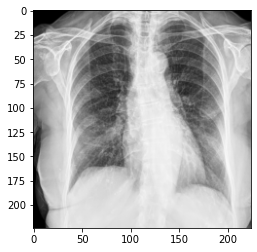

In [31]:
Image_Path =  r"C:\Users\Teja Nikhil\OneDrive\Desktop\4a268497915a5767723b1f2d9723cc_jumbo.jpeg"
Image = readImage(Image_Path)
plt.imshow(Image)

Number of Super pixels generated: 69


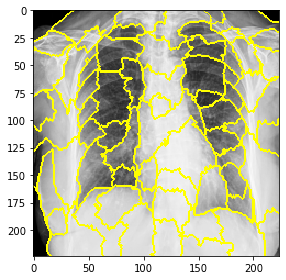

In [32]:
# draw_Img(Image)
num_superpixels , super_pixels = Generate_Superpixels(Image, 200)
skimage.io.imshow(skimage.segmentation.mark_boundaries(Image, super_pixels))

Changes in the superpixels in each perturbations are: 69
Number of perturbations: 150


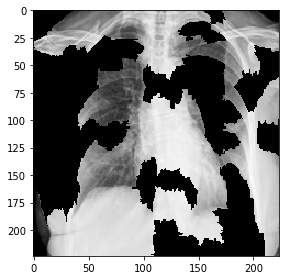

In [33]:
perturbations = Generate_Perturbations(150)
skimage.io.imshow(perturb_Image(Image, perturbations[0],super_pixels))

In [34]:
Perturbated_Df = pd.DataFrame(perturbations.flatten())
Perturbated_Df.shape
predictions = []

In [35]:
for pert in perturbations:
    perturbed_img = perturb_Image(Image,pert,super_pixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

In [36]:
predictions = np.array(predictions)

In [37]:
distances = Compute_Distances(num_superpixels, perturbations)

weights = Compute_weights(distances, 0.25)

In [38]:
coeffs = fit_weights(perturbations, predictions, weights)

[[0.00087252]]


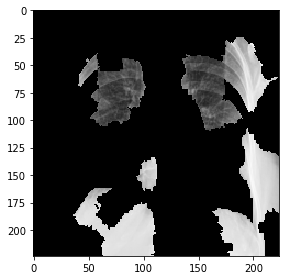

In [41]:
print(model.predict(Image[np.newaxis,:,:,:]))
mask_image(Image, num_superpixels, super_pixels, 15, coeffs)